# generate quantum dataset

In [1]:
import qsvm.Qmapping as Q
import qsvm.data_function as df
import numpy as np
import matplotlib.pyplot as plt
from qsvm.qsvm import Pca,QSVM
from qsvm.quantum_data_generator import QDataGenerator


In [2]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse


In [3]:
data_g=QDataGenerator()

In [4]:
f = open('./Datasets/cifar10.json', 'r') 
tg = json.load(f)
f.close()
traindata = tg['train']['data'][:400]
testdata = tg['test']['data'][:200]
trainlabels = tg['train']['label'][:400]
testlabels = tg['test']['label'][:200]

In [5]:
# PCA
pca=Pca(PCA_n=10,StandardizeOrNot=False,sklearnPCA=True)
pca.fitting(traindata)
svm_tr_data=pca.transform(traindata)
svm_te_data=pca.transform(testdata)

# Renormalize each feature
svm_tr_data=pca.Renormalize_Each_Feature(svm_tr_data,Norm=np.pi/2,status="train")
svm_te_data=pca.Renormalize_Each_Feature(svm_te_data,Norm=np.pi/2)

In [6]:
data_g.data=np.array(svm_tr_data.tolist()+svm_te_data.tolist())
data_g.data_n=len(data_g.data)

In [7]:
data_g.encoding_data()

In [8]:
data_g.generate_QNN(tier=10,QNN_method="analog",atomn=10,aR0=1,detuning=0,rabi=1,t=np.pi)

In [9]:
data_g.generate_labels(observable="z",atom_ind=1)

In [10]:
trainlabels=np.real(data_g.labels_list[:400])
testlabels=np.real(data_g.labels_list[400:])

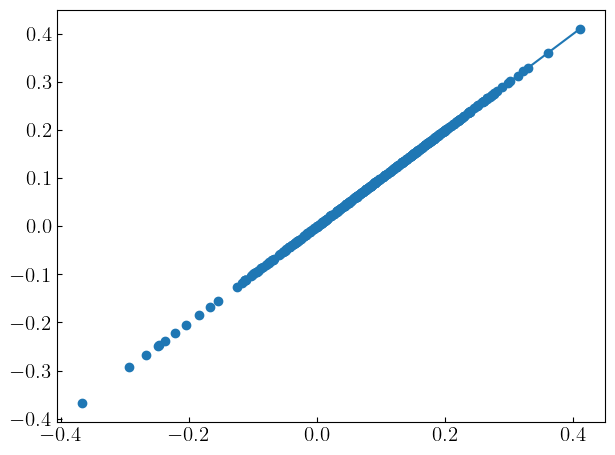

In [11]:
df._plot(trainlabels , trainlabels , 99 , name = '',start=0,end=max(trainlabels))

In [12]:
# Save dataset
tg={}
tg["train"]={}
tg["test"]={}
f1 = open('./Datasets/cifar10_QNN.json', 'a+') 

tg['train']['data']=traindata
tg['test']['data']=testdata
tg['train']['label']=trainlabels.tolist()
tg['test']['label']=testlabels.tolist()

json.dump(tg , f1)
f1.close()

# check dataset

In [13]:
import time

In [14]:
qsvm=QSVM(task='svr')
qsvm.default_phys_sys()

In [15]:
# error=[0.005,0.01,0.1]
error=[]
method="hybrid"
start_time = time.time()
tr_kernel=qsvm.get_kernel(svm_tr_data,tier=1,method=method, op="x",Error=error)
te_kernel=qsvm.get_kernel(svm_te_data,status="test",tier=1,method=method, op="x",Error=error)
end_time=time.time()

In [16]:
cost_time=end_time-start_time

In [17]:
print(cost_time)

13.605633020401001


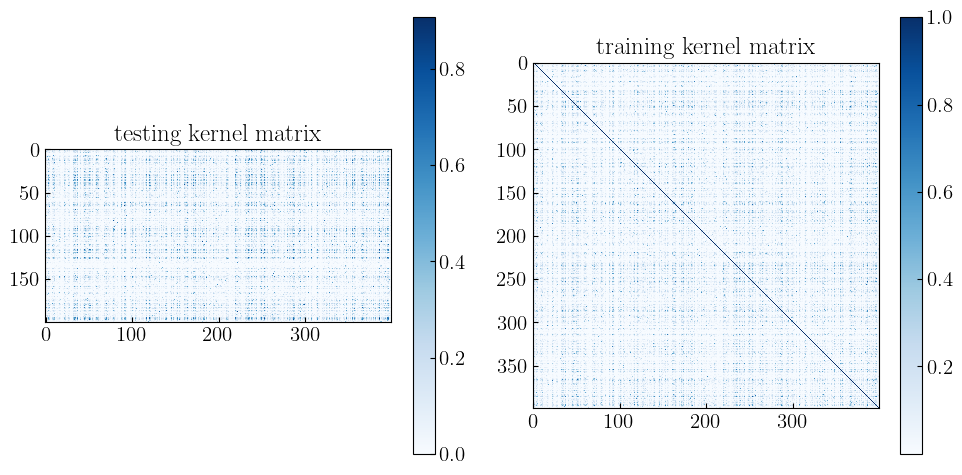

In [18]:
Q.show_kmatrix(train = tr_kernel , test = te_kernel,name = "")

## Supported Vector Machine

### Quantum kernel

In [19]:
from sklearn.svm import SVR
import sklearn

In [50]:
# svr = SVR()
argv = df._tune(np.array(tr_kernel) , trainlabels ,np.array(te_kernel) , testlabels, ['precomputed'] , tg = 'ts' )
argv

{'kernel': 'precomputed', 'epsilon': 0.0, 'C': 0.9}

In [62]:
qsvm.fit(tr_kernel, trainlabels, epsilon = argv['epsilon'] , C = 1)

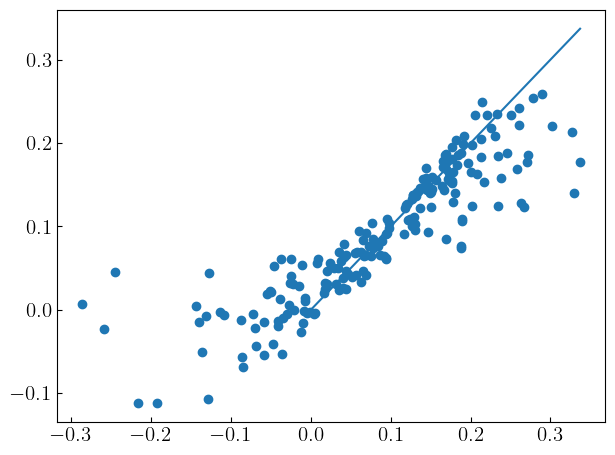

In [63]:
rs_t=qsvm.predict(te_kernel)
df._plot(testlabels , rs_t , 99 , name = '',start=0,end=max(testlabels))

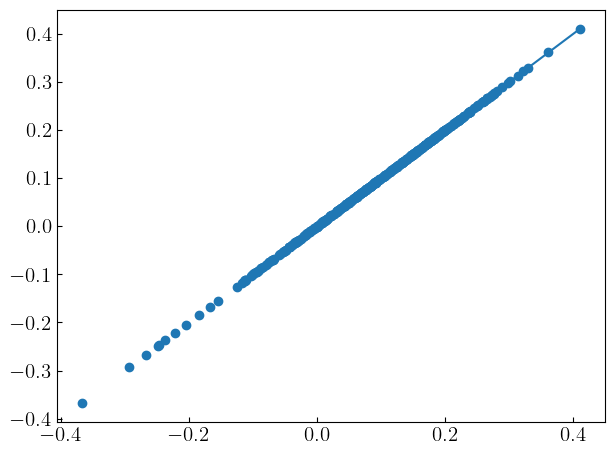

In [64]:
rs = qsvm.predict(tr_kernel)
df._plot(trainlabels , rs ,99 , name = '',start=0,end=max(trainlabels))

### linear

In [24]:

traindata=np.array(svm_tr_data)
testdata=np.array(svm_te_data)

_k = sklearn.metrics.pairwise.linear_kernel(svm_tr_data)
_kk = sklearn.metrics.pairwise.linear_kernel(svm_te_data,svm_tr_data)

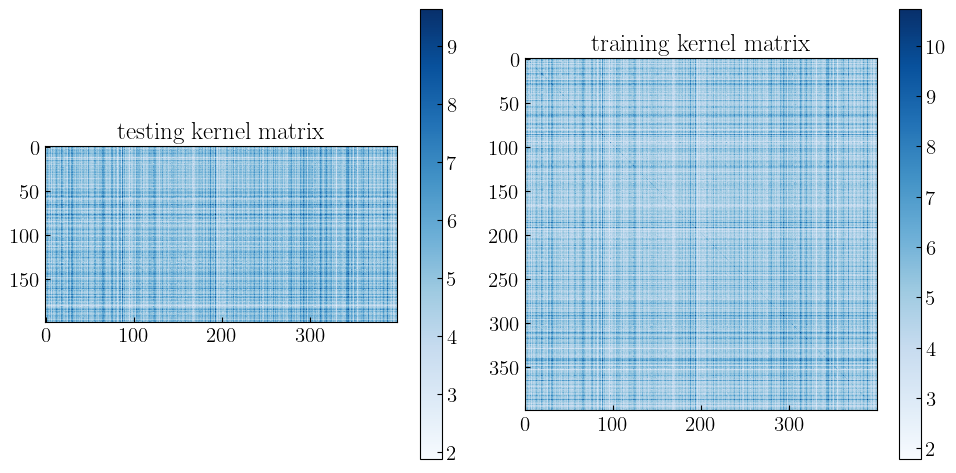

In [25]:
Q.show_kmatrix(test = _kk , train = _k , name = '')

In [26]:
mth = 'linear'
linear_svr = SVR()
argv = df.tune(linear_svr,svm_tr_data , trainlabels , [mth])
argv

{'kernel': 'linear', 'epsilon': 0.057, 'C': 0.30000000000000004}

In [27]:
linear_svr = SVR(kernel = mth , epsilon = 0, C=0.9)
linear_svr.fit(svm_tr_data, trainlabels)

SVR(C=0.9, epsilon=0, kernel='linear')

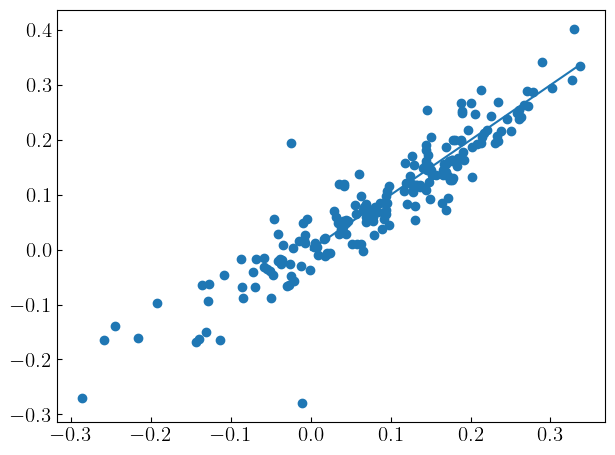

In [28]:
linear_rs_t = linear_svr.predict(svm_te_data)
df._plot(testlabels , linear_rs_t , 999 , name = '',start=0,end=max(testlabels))

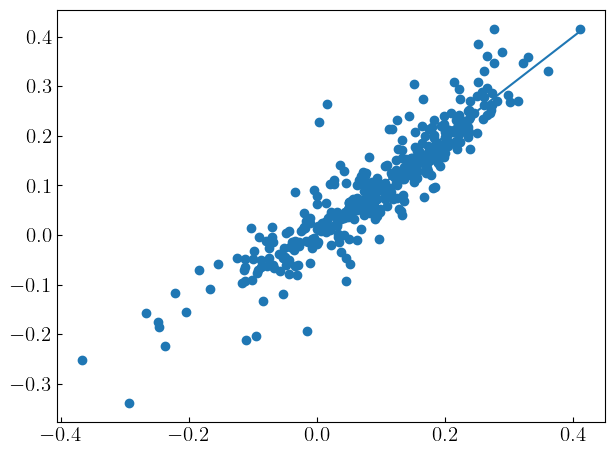

In [29]:
linear_rs = linear_svr.predict(svm_tr_data)
df._plot(trainlabels , linear_rs , 999 , name = '',start=0,end=max(trainlabels))

### rbf

In [30]:

traindata=np.array(svm_tr_data)
testdata=np.array(svm_te_data)

_k = sklearn.metrics.pairwise.rbf_kernel(svm_tr_data,gamma=1/(10*traindata.var()))
_kk = sklearn.metrics.pairwise.rbf_kernel(svm_te_data,svm_tr_data,gamma=1/(10*traindata.var()))

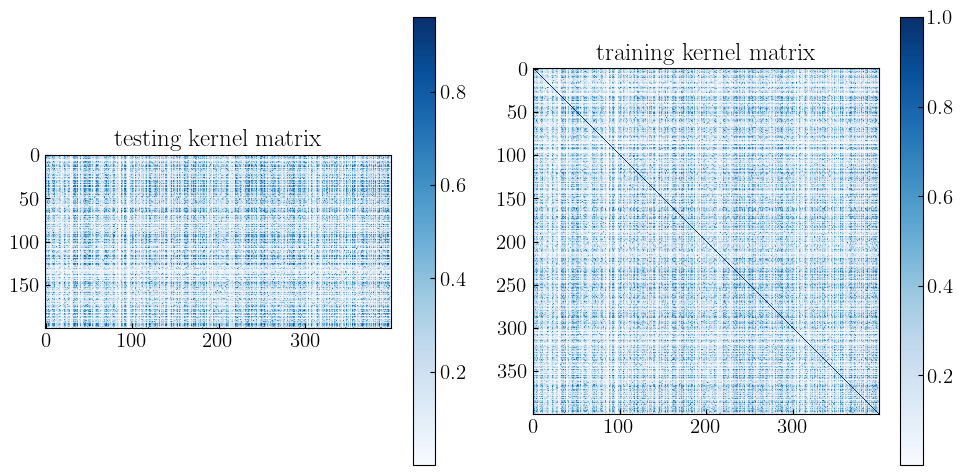

In [31]:
Q.show_kmatrix(test = _kk , train = _k , name = '')

In [32]:
mth = 'rbf'
_svr = SVR()
argv = df.tune(_svr,svm_tr_data , trainlabels , [mth])
argv

{'kernel': 'rbf', 'epsilon': 0.214, 'C': 0.5}

In [33]:
_svr = SVR(kernel = mth , epsilon = 0, C=0.9)
_svr.fit(svm_tr_data, trainlabels)

SVR(C=0.9, epsilon=0)

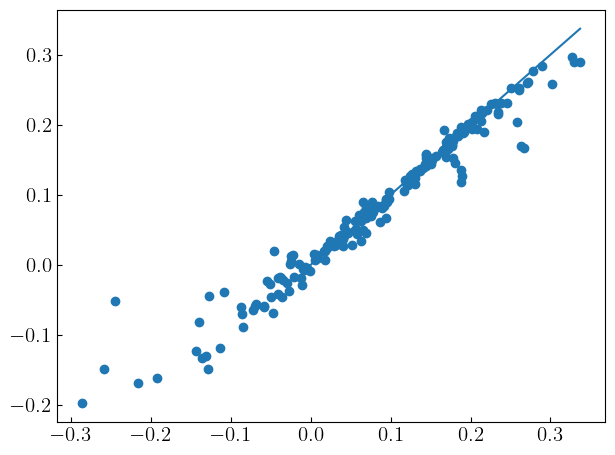

In [34]:
_rs_t = _svr.predict(svm_te_data)
df._plot(testlabels , _rs_t , 999 , name = '',start=0,end=max(testlabels))

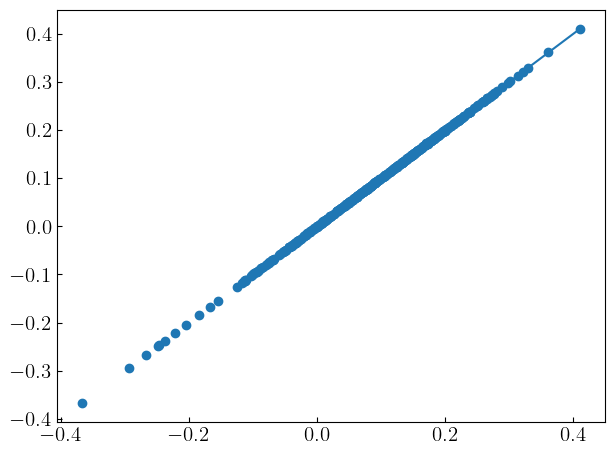

In [35]:
_rs = _svr.predict(svm_tr_data)
df._plot(trainlabels , _rs , 999 , name = '',start=0,end=max(trainlabels))

## Result

In [65]:
print(f'Classical linear testing mse : {mse(linear_rs_t , testlabels)}')
print(f'Classical rbf testing mse : {mse(_rs_t , testlabels)}')
print(f'Quantum testing mse : {mse(rs_t,testlabels)}')

Classical linear testing mse : 0.0020454818848936207
Classical rbf testing mse : 0.000720327100719841
Quantum testing mse : 0.0035844815786107154


In [66]:
print(f'Classical linear training mse : {mse(linear_rs , trainlabels)}')
print(f'Classical rbf training mse : {mse(_rs , trainlabels)}')
print(f'Quantum training mse : {mse(rs,trainlabels)}')

Classical linear training mse : 0.002196375463218604
Classical rbf training mse : 7.245655712481669e-08
Quantum training mse : 5.5160994907287845e-08
